In [2]:
import concurrent.futures
import glob
import os
import re
import subprocess
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import circmean
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [3]:
def calculate_heading_difference(pre_heading, post_heading):
    # Calculate the angular difference considering the circular nature
    diff = post_heading - pre_heading
    
    # Normalize to [-π, π] range
    return np.arctan2(np.sin(diff), np.cos(diff))

In [4]:
# Base folder with all slp files
slp_base_folder = "/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/"

# subfolders with CS and native SLP files
cs_slp_folder = os.path.join(slp_base_folder, "wildtype-cs")
native_slp_folder = os.path.join(slp_base_folder, "native")

# Get all subfolders in the CS and native SLP folders
# where each folder is a collection of videos from a different braidz recording
cs_slp_subfolders = sorted(glob.glob(os.path.join(cs_slp_folder, "*")))
native_slp_subfolders = sorted(glob.glob(os.path.join(native_slp_folder, "*")))

# setup output folder
cs_output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/"
native_output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/"

In [5]:
# Define a worker function that processes a single file
def process_file(file_info):
    file, exp_output_folder = file_info  # Unpack the tuple

    # set the output filename
    output_file = os.path.join(
        exp_output_folder, os.path.basename(file).replace(".slp", ".csv")
    )

    # if file exists, skip
    if os.path.exists(output_file):
        return f"Skipping {file} (already converted)"

    # convert to csv
    cmd = ["sleap-convert", file, "--format", "analysis.csv", "--output", output_file]

    # To log output to a file instead of discarding it
    with open(os.path.join(exp_output_folder, "conversion.log"), "a") as log_file:
        subprocess.run(cmd, stdout=log_file, stderr=log_file)

    return f"Converted {file}"


def process_folders(input_folders, output_folders, workers=None):
    """
    A function to convert all the slp files from the input folders to csv files in the output folders.
    
    Parameters:
        input_folders (list): List of input folders, each containing slp files.
        output_folders (str): Path to the output folder where the converted files will be saved.
        workers (int): Number of worker processes to use for parallel processing. If None, defaults to the number of CPU cores.
    """
    # loop over each exp folders (meaning, each folder from a braidz file containing all the slp files)
    for exp_folder in input_folders:

        # find all slp files in each folder
        exp_files = sorted(glob.glob(os.path.join(exp_folder, "*.slp")))

        # setup output folder (same name as exp_folder)
        exp_output_folder = os.path.join(
            output_folders, os.path.basename(os.path.normpath(exp_folder))
        )
        os.makedirs(exp_output_folder, exist_ok=True)

        # Prepare input data for process_map
        file_data = [(file, exp_output_folder) for file in exp_files]

        # Process files in parallel with progress bar using process_map
        results = process_map(
            process_file,
            file_data,
            max_workers=workers,
            chunksize=10,
            desc=f"Processing {os.path.basename(exp_folder)}",
            leave=True,
        )


process_folders(native_slp_subfolders, native_output_folder)

Processing 20241112_124059:   0%|          | 0/28 [00:00<?, ?it/s]

Processing 20241114_173118:   0%|          | 0/37 [00:00<?, ?it/s]

Processing 20241116_154109:   0%|          | 0/42 [00:00<?, ?it/s]

Processing 20241125_132912:   0%|          | 0/125 [00:00<?, ?it/s]

Processing 20241127_152044:   0%|          | 0/125 [00:00<?, ?it/s]

Processing 20241129_144233:   0%|          | 0/125 [00:00<?, ?it/s]

Processing 20241202_153526:   0%|          | 0/109 [00:00<?, ?it/s]

Processing 20250106_153631:   0%|          | 0/41 [00:00<?, ?it/s]

Processing 20250108_160315:   0%|          | 0/125 [00:00<?, ?it/s]

Processing 20250116_154619:   0%|          | 0/125 [00:00<?, ?it/s]

Processing 20250120_173635:   0%|          | 0/125 [00:00<?, ?it/s]

Processing 20250125_150808:   0%|          | 0/125 [00:00<?, ?it/s]

In [10]:
def process_data(stim_csvs_folder, pre_range = [0, 250], post_range = [400, 750]):
    """
    This function accepts a folder with all the csv files that contain the stimulus data as 
    extracted from the braid recording.
    Then, for each file, it finds the correct folder with the converted slp files, and 
    inside that folder finds the correct file that matches each row (obj_id + frame) in the stim csv file.

    It then loads the data from that file, and calculates the heading difference between pre and post
    stimulus data, as well as the heading difference between pre stimulus and the stimulus heading.
    The results are returned as a pandas DataFrame.

    Parameters:
        stim_csvs_folder (str): The folder containing the stimulus CSV files.
        pre_range (list): The range of frames to consider for pre-stimulus data.
        post_range (list): The range of frames to consider for post-stimulus data.

    Returns:
        pd.DataFrame: A DataFrame containing the processed data with heading differences.
    """
    # Create an empty list to collect all the data
    all_data = []

    # get all csv files in the stim_csvs_folder (these are the stim files)
    stim_csvs = sorted(glob.glob(os.path.join(stim_csvs_folder, "*.csv")))
    
    # define pattern recognition for filenames
    pattern = r"obj_id_(\d+)_frame_(\d+)"

    # loop over all files
    for stim_csv in stim_csvs:

        print(f"==== Processing {stim_csv} ====")
        stim_df = pd.read_csv(stim_csv) # read the csv

        # now get the correct folder for the stim file
        slp2csv_folder = os.path.join(stim_csvs_folder,
            os.path.join(os.path.basename(os.path.normpath(stim_csv)).replace(".csv", ""))
            )
        
        # and get all the files from that folder
        slp2csv_files = sorted(glob.glob(os.path.join(slp2csv_folder, "*.csv")))
        
        # loop over the rows of each stim file
        for idx, row in stim_df.iterrows():

            # extract data for each stim row
            stim_obj_id = int(row["obj_id"])
            stim_frame = int(row["frame"])
            stim_heading = float(row["stim_heading"])
            
            # Find the matching csv file
            matching_file = None
            for file in slp2csv_files:
                match = re.search(pattern, file)
                if match:
                    file_obj_id = int(match.group(1))
                    file_frame = int(match.group(2))
                    
                    if file_obj_id == stim_obj_id and file_frame == stim_frame:
                        matching_file = file
                        break
            
            # if no matching file was found, skip
            if matching_file is None:
                continue

            # Load the matching file
            data_df = pd.read_csv(matching_file)

            # interpolate missing values
            data_df_interp = data_df.interpolate(method="linear", limit_direction="both", limit=10)

            # extract all data
            frames = data_df_interp["frame_idx"].to_numpy()
            head_x = data_df_interp["head.x"].to_numpy()
            head_y = data_df_interp["head.y"].to_numpy()
            abdomen_x = data_df_interp["abdomen.x"].to_numpy()
            abdomen_y = data_df_interp["abdomen.y"].to_numpy()

            # get indices
            pre_indices = np.where((frames >= pre_range[0]) & (frames < pre_range[1]))[0]
            post_indices = np.where((frames >= post_range[0]) & (frames < post_range[1]))[0]

            # Skip if no data in these ranges
            if len(pre_indices) == 0 or len(post_indices) == 0:
                continue
            
            # get pre data
            head_x_pre = head_x[pre_indices]
            head_y_pre = head_y[pre_indices]
            abdomen_x_pre = abdomen_x[pre_indices]
            abdomen_y_pre = abdomen_y[pre_indices]

            # get post data
            head_x_post = head_x[post_indices]
            head_y_post = head_y[post_indices]
            abdomen_x_post = abdomen_x[post_indices]
            abdomen_y_post = abdomen_y[post_indices]

            # calculate heading
            pre_heading = np.arctan2(head_y_pre - abdomen_y_pre, head_x_pre - abdomen_x_pre)
            post_heading = np.arctan2(head_y_post - abdomen_y_post, head_x_post - abdomen_x_post)
            
            # get mean pre and post heading
            pre_heading_mean = circmean(pre_heading, high=np.pi, low=-np.pi)
            post_heading_mean = circmean(post_heading, high=np.pi, low=-np.pi)

            # calculate heading difference
            try:
                prepost_heading_difference = calculate_heading_difference(post_heading_mean, pre_heading_mean)
                # calculate heading difference between pre_heading and stim_heading
                prestim_heading_difference = calculate_heading_difference(stim_heading, pre_heading_mean)
                
                # Create a copy of the row data and add the new calculations
                row_data = row.to_dict()  # Convert the row to a dictionary
                row_data['prepost_heading_difference'] = prepost_heading_difference
                row_data['prestim_heading_difference'] = prestim_heading_difference
                row_data['pre_heading'] = pre_heading_mean
                row_data['post_heading'] = post_heading_mean
                # Append to the all_data list
                all_data.append(row_data)
                
            except ValueError as e:
                print(f"Error calculating heading difference: {e}")
                continue

    # Create a DataFrame from all the collected data
    result_df = pd.DataFrame(all_data)

    # Now result_df contains all the data from all files with the heading differences
    print(f"Combined DataFrame has {len(result_df)} rows")
    return result_df

cs_results_df = process_data("/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/")
native_results_df = process_data("/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/")

==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20241121_151406.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20241126_171308.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20241130_161634.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250102_152013.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250110_142709.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250111_151946.csv ====
Combined DataFrame has 66 rows
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241112_124059.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241114_173118.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241116_154109.csv ====
==== Processing /gpfs/soma_fs/home/buch

In [13]:
cs_results_df

,obj_id,frame,stim_heading,prepost_heading_difference,prestim_heading_difference,pre_heading,post_heading
0,3606.0,1630270.0,1.193178,NaN,NaN,NaN,-1.713076
1,3615.0,1649124.0,1.926853,NaN,NaN,NaN,-1.441799
2,633.0,898182.0,-0.757202,0.020992,-2.302792,-3.059994,-3.080986
3,633.0,898807.0,-1.728550,-1.802772,1.389668,-0.338882,1.463890
4,921.0,1335278.0,0.721428,-0.122983,-2.006424,-1.284996,-1.162012
...,...,...,...,...,...,...,...
61,11112.0,1543536.0,-0.482455,NaN,NaN,NaN,NaN
62,11463.0,1551778.0,-0.242697,NaN,0.499843,0.257146,NaN
63,19643.0,1845431.0,-0.820195,-1.576556,1.013367,0.193172,1.769727
64,23742.0,2467121.0,1.301258,0.073686,-1.405058,-0.103800,-0.177485


In [15]:
def plot_correlation(df, col1, col2, use_abs=False, convert_to_degrees=True, title=None, 
                     xlabel=None, ylabel=None, figsize=(10, 6)):
    """
    Plot correlation between two columns in the dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot
    col1 : str
        The name of the first column to plot (x-axis)
    col2 : str
        The name of the second column to plot (y-axis)
    use_abs : bool, default=False
        Whether to use absolute values for the columns
    convert_to_degrees : bool, default=True
        Whether to convert radian values to degrees
    title : str, optional
        Custom title for the plot
    xlabel : str, optional
        Custom label for x-axis
    ylabel : str, optional
        Custom label for y-axis
    figsize : tuple, default=(10, 6)
        Figure size as (width, height) in inches
    """
    # Create a copy to avoid modifying the original dataframe
    plot_df = df.copy()
    
    # Process the columns based on parameters
    x_col = f'abs_{col1}' if use_abs else col1
    y_col = f'abs_{col2}' if use_abs else col2
    
    # Create absolute value columns if needed
    if use_abs:
        plot_df[x_col] = np.abs(plot_df[col1])
        plot_df[y_col] = np.abs(plot_df[col2])
    
    # Convert to degrees if requested
    if convert_to_degrees:
        x_col_plot = f'{x_col}_deg'
        y_col_plot = f'{y_col}_deg'
        plot_df[x_col_plot] = np.degrees(plot_df[x_col])
        plot_df[y_col_plot] = np.degrees(plot_df[y_col])
    else:
        x_col_plot = x_col
        y_col_plot = y_col
    
    # Generate labels if not provided
    if xlabel is None:
        prefix = '|' if use_abs else ''
        suffix = '|' if use_abs else ''
        unit = ' (degrees)' if convert_to_degrees else ' (radians)'
        xlabel = f"{prefix}{col1}{suffix}{unit}"
    
    if ylabel is None:
        prefix = '|' if use_abs else ''
        suffix = '|' if use_abs else ''
        unit = ' (degrees)' if convert_to_degrees else ' (radians)'
        ylabel = f"{prefix}{col2}{suffix}{unit}"
    
    if title is None:
        abs_prefix = "Absolute " if use_abs else ""
        title = f"{abs_prefix}Correlation: {col1} vs {col2}"
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Scatter plot
    plt.scatter(plot_df[x_col_plot], plot_df[y_col_plot], alpha=0.6)
    
    # Add trend line
    sns.regplot(x=x_col_plot, y=y_col_plot, data=plot_df, 
                scatter=False, color='red')
    
    # Calculate and display correlation coefficient
    corr = plot_df[x_col].corr(plot_df[y_col])
    plt.annotate(f'r = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Return the plot for further customization if needed
    return plt

Text(0.5, 1.0, 'native')

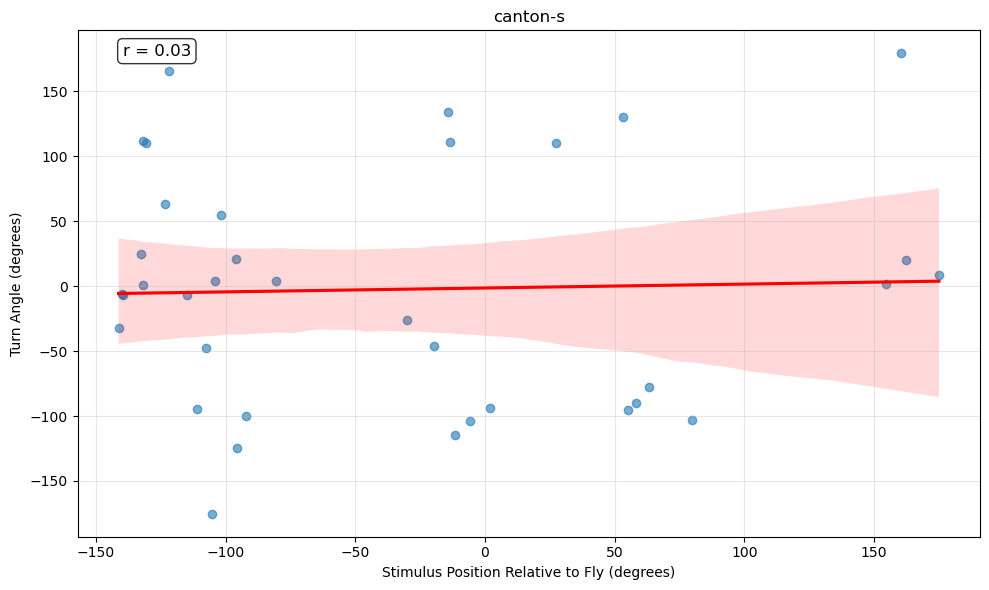

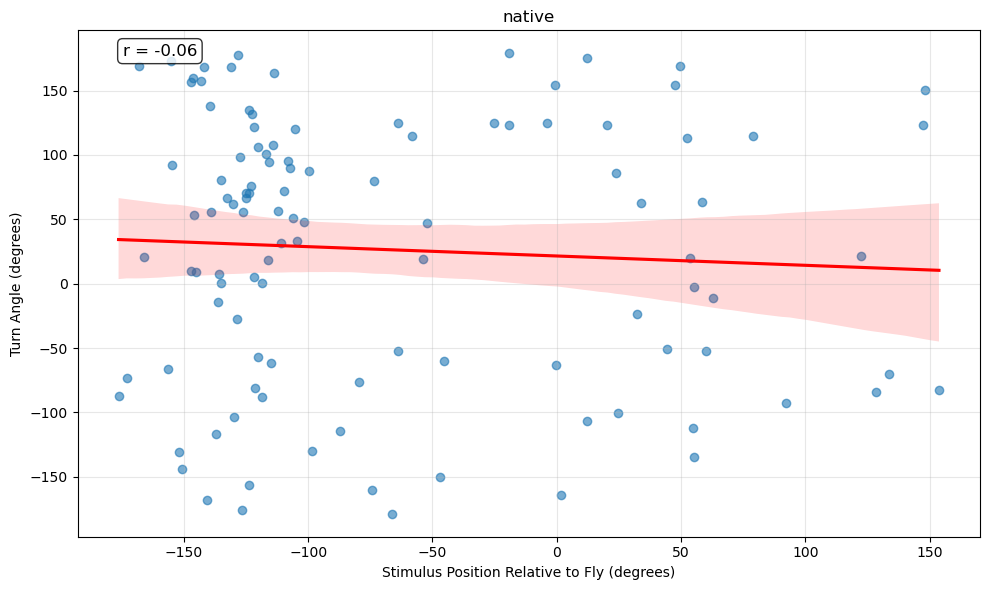

In [20]:
"""
This plot shows if flies turn toward or away from the stimulus

A negative correlation means flies tend to turn away from the stimulus
A positive correlation means flies tend to turn toward the stimulus
If points are in opposite quadrants (top-left and bottom-right), this indicates turning away
Look at the trend line slope to determine the dominant behavior
"""

p = plot_correlation(cs_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
                 use_abs=False, 
                 title='Turn Direction Relative to Stimulus Position (CS)',
                 xlabel='Stimulus Position Relative to Fly (degrees)',
                 ylabel='Turn Angle (degrees)')

p = plot_correlation(native_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
                 use_abs=False, 
                 title='Turn Direction Relative to Stimulus Position (Native)',
                 xlabel='Stimulus Position Relative to Fly (degrees)',
                 ylabel='Turn Angle (degrees)')

<module 'matplotlib.pyplot' from '/gpfs/soma_fs/home/buchsbaum/miniforge3/envs/sleap/lib/python3.7/site-packages/matplotlib/pyplot.py'>

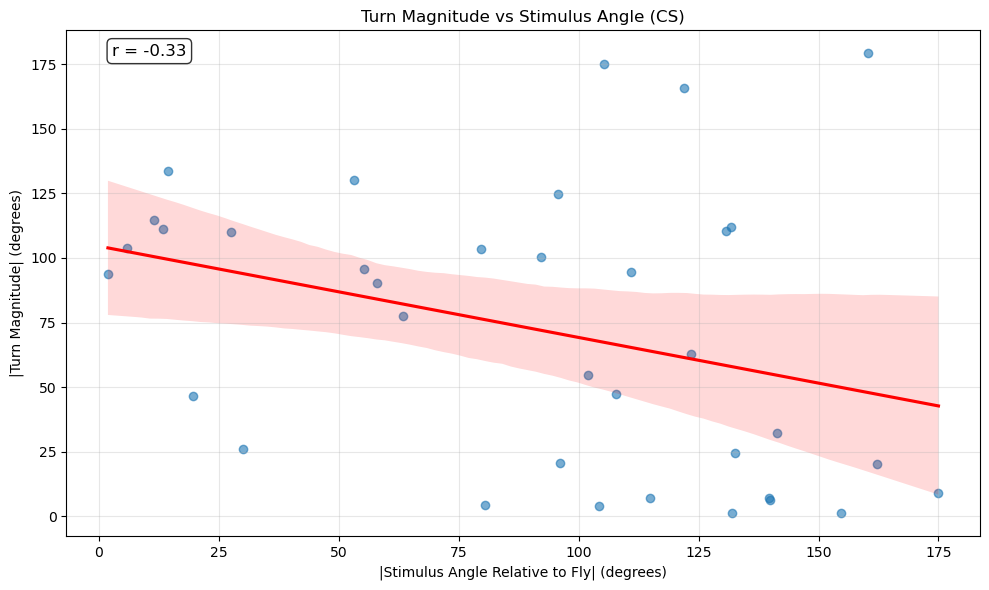

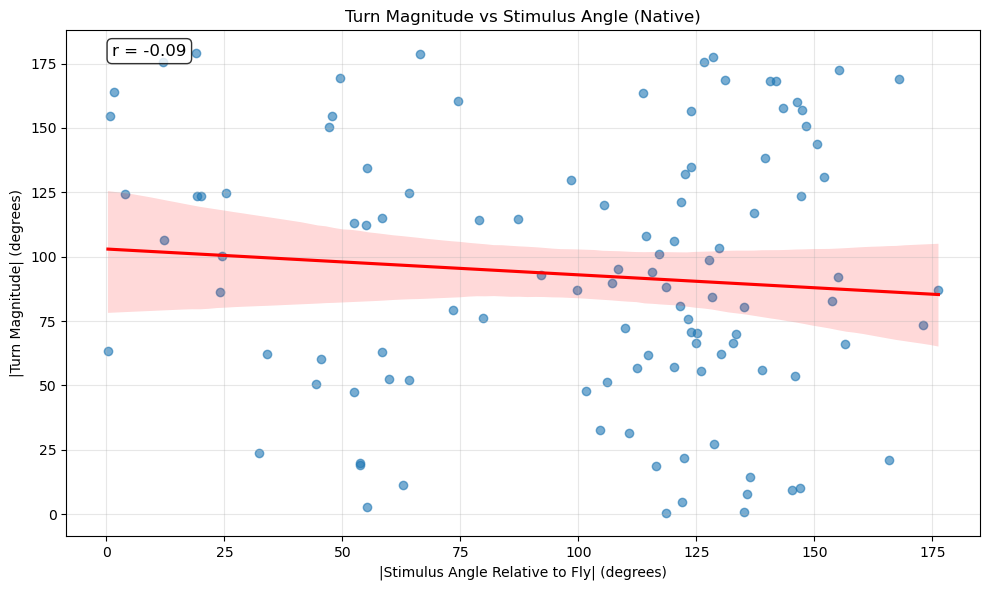

In [21]:
"""
This plot shows if stimulus angle affects turn amplitude
This shows if flies make sharper turns when stimuli come from certain angles
A positive correlation suggests stronger turns when the stimulus is more lateral
A flat line suggests turn magnitude is independent of stimulus position
"""
plot_correlation(cs_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
                 use_abs=True,
                 title='Turn Magnitude vs Stimulus Angle (CS)',
                 xlabel='|Stimulus Angle Relative to Fly| (degrees)',
                 ylabel='|Turn Magnitude| (degrees)')

plot_correlation(native_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
                 use_abs=True,
                 title='Turn Magnitude vs Stimulus Angle (Native)',
                 xlabel='|Stimulus Angle Relative to Fly| (degrees)',
                 ylabel='|Turn Magnitude| (degrees)')


<module 'matplotlib.pyplot' from '/gpfs/soma_fs/home/buchsbaum/miniforge3/envs/sleap/lib/python3.7/site-packages/matplotlib/pyplot.py'>

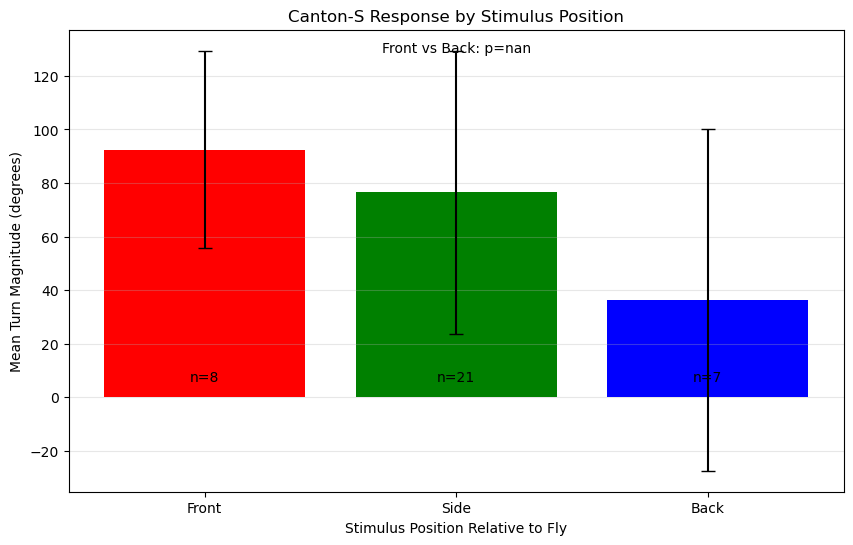

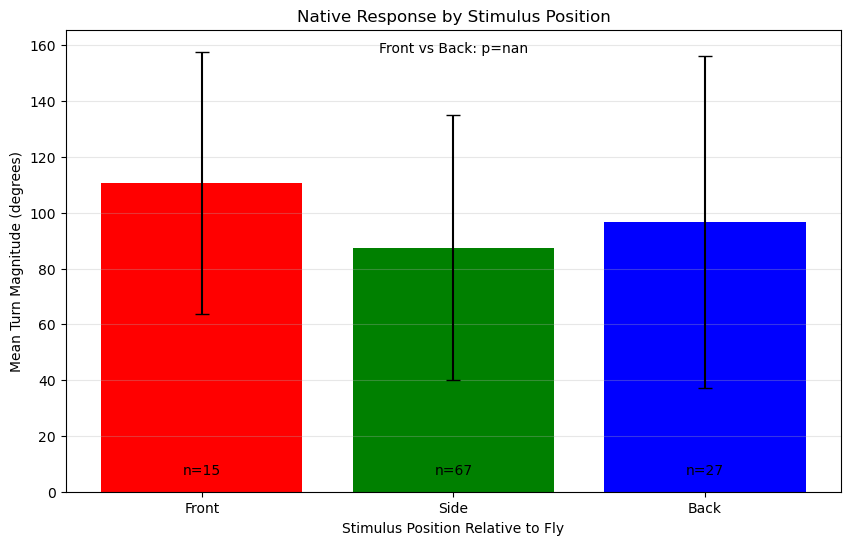

In [24]:
def analyze_directional_response(df, title="Directional Response Analysis"):
    # Create a copy of the dataframe
    analysis_df = df.copy()
    
    # Convert to degrees for easier interpretation
    analysis_df['prestim_deg'] = np.degrees(analysis_df['prestim_heading_difference'])
    analysis_df['turn_magnitude'] = np.abs(np.degrees(analysis_df['prepost_heading_difference']))
    
    # create the position categories manually
    def get_position(angle):
        angle = ((angle + 180) % 360) - 180  # Normalize to [-180, 180]
        if -45 <= angle <= 45:
            return 'Front'
        elif 135 <= angle <= 180 or -180 <= angle <= -135:
            return 'Back'
        else:
            return 'Side'
    
    # Apply the function to create position categories
    analysis_df['position'] = analysis_df['prestim_deg'].apply(get_position)
    
    # Calculate statistics for each position
    position_stats = analysis_df.groupby('position')['turn_magnitude'].agg(
        ['mean', 'std', 'count']).reset_index()
    
    # For consistent visual ordering
    position_order = ['Front', 'Side', 'Back']
    position_stats['position'] = pd.Categorical(
        position_stats['position'], 
        categories=position_order, 
        ordered=True
    )
    position_stats = position_stats.sort_values('position')
    
    # Colors for the bars
    colors = {'Front': 'red', 'Side': 'green', 'Back': 'blue'}
    bar_colors = [colors[pos] for pos in position_stats['position']]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    
    # Create bar plot with error bars
    bars = plt.bar(position_stats['position'], position_stats['mean'], 
            yerr=position_stats['std'], capsize=5, color=bar_colors)
    
    # Add count labels
    for i, bar in enumerate(bars):
        count = position_stats['count'].iloc[i]
        plt.text(bar.get_x() + bar.get_width()/2, 5, 
                 f'n={count}', ha='center', va='bottom')
    
    plt.xlabel('Stimulus Position Relative to Fly')
    plt.ylabel('Mean Turn Magnitude (degrees)')
    plt.title(title)
    plt.grid(True, alpha=0.3, axis='y')
    
    return plt

# Compare both strains
analyze_directional_response(cs_results_df, "Canton-S Response by Stimulus Position")
analyze_directional_response(native_results_df, "Native Response by Stimulus Position")


Canton-S - Percentage turning toward stimulus by position:
Back-Left: 54.5% toward (n=11)
Left: 60.0% toward (n=10)
Front-Left: 12.5% toward (n=8)
Front-Right: 0.0% toward (n=6)
Right: 0.0% toward (n=3)
Back-Right: 100.0% toward (n=4)

Native - Percentage turning toward stimulus by position:
Back-Left: 57.4% toward (n=47)
Left: 25.9% toward (n=27)
Front-Left: 5.9% toward (n=17)
Front-Right: 16.7% toward (n=18)
Right: 33.3% toward (n=3)
Back-Right: 50.0% toward (n=8)


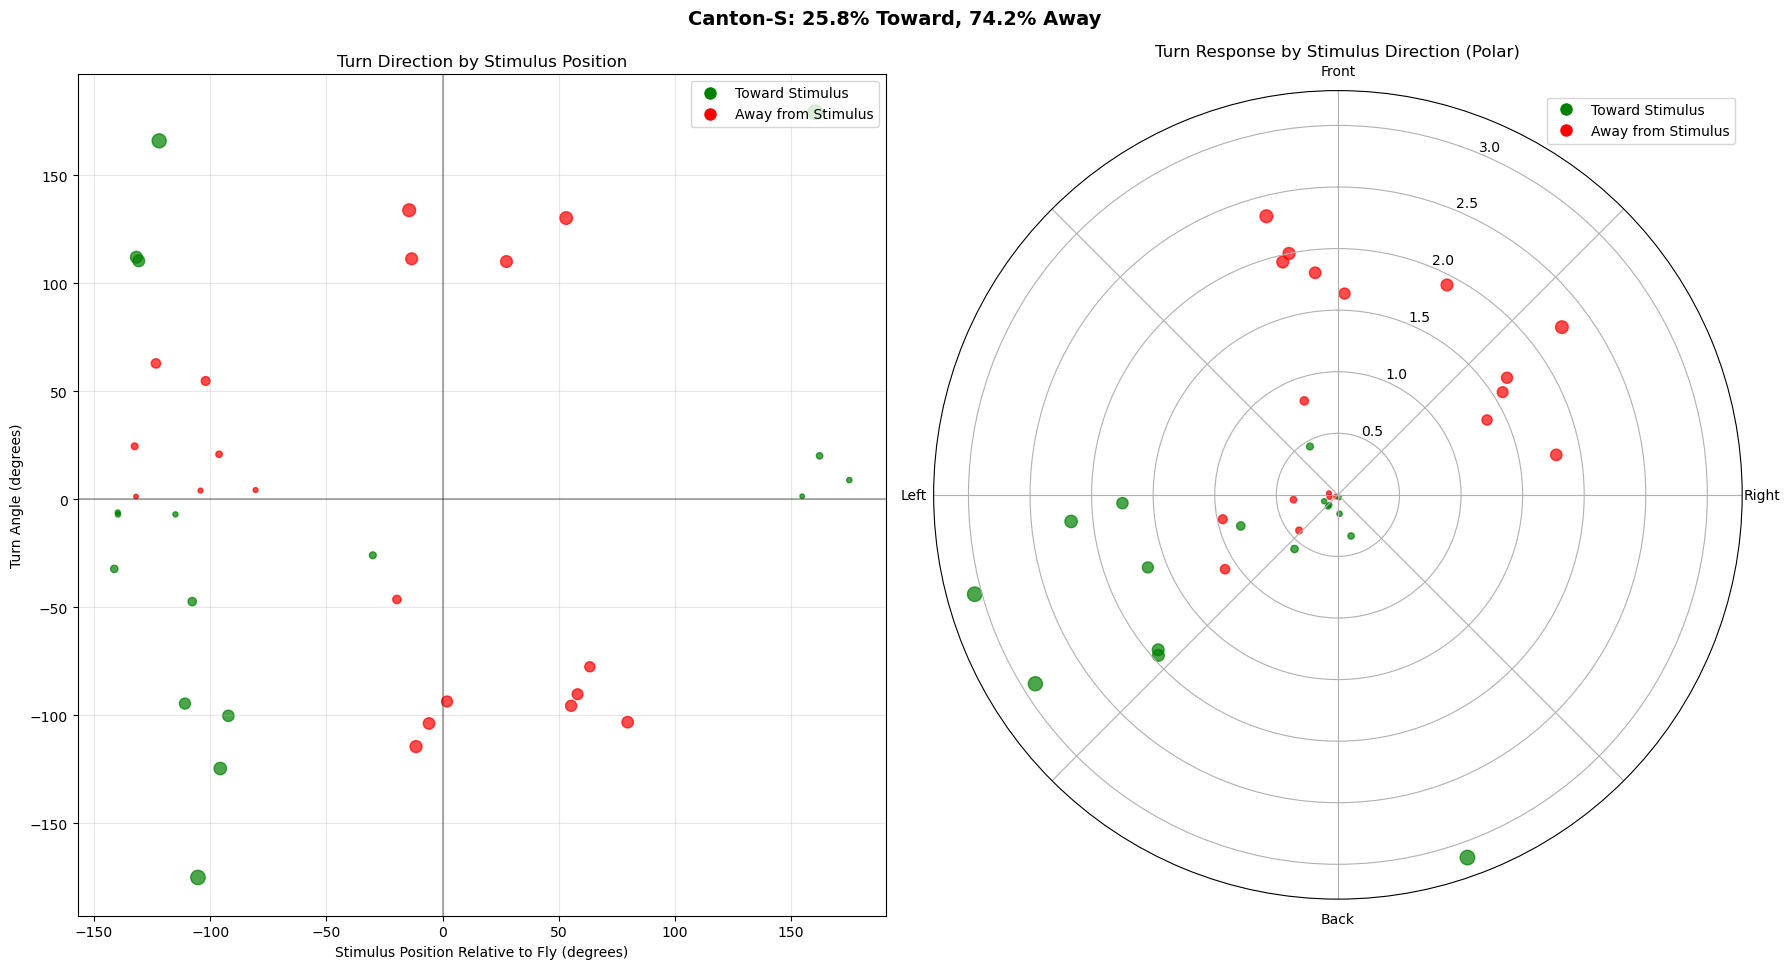

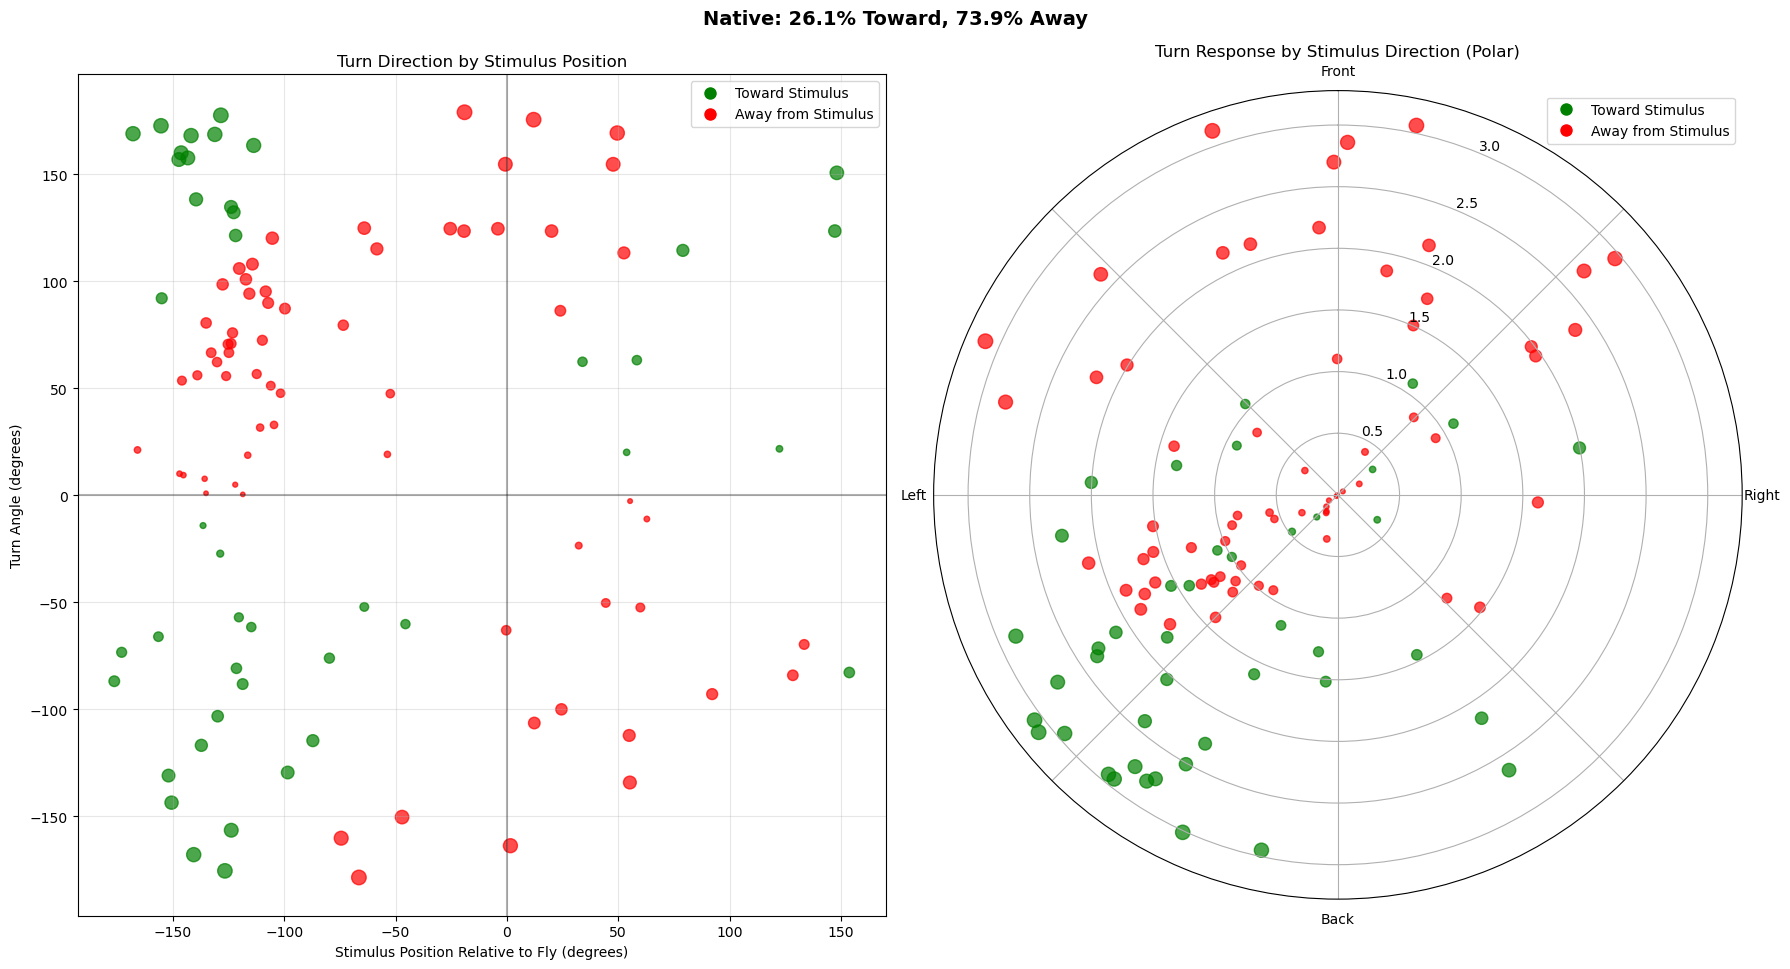

In [25]:
def analyze_turn_direction(df, title="Turn Direction Analysis"):
    """
    Analyze whether flies turned toward or away from the stimulus.
    """
    # Create a copy of the dataframe
    analysis_df = df.copy()
    
    # Calculate post-stimulus to stimulus heading difference
    analysis_df['poststim_diff'] = np.abs(np.degrees(
        calculate_heading_difference(
            analysis_df['stim_heading'], 
            analysis_df['post_heading']
        )
    ))
    
    # Get absolute pre-stimulus heading difference
    analysis_df['prestim_diff_abs'] = np.abs(np.degrees(analysis_df['prestim_heading_difference']))
    
    # Determine if the fly turned toward or away from the stimulus
    # If the angle to the stimulus decreased after turning, it turned toward
    analysis_df['turn_direction'] = np.where(
        analysis_df['poststim_diff'] < analysis_df['prestim_diff_abs'],
        'Toward',
        'Away'
    )
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 10))
    
    # 1. Scatter plot of turn direction
    ax1 = fig.add_subplot(121)
    
    # Convert to degrees for plot
    prestim_deg = np.degrees(analysis_df['prestim_heading_difference'])
    turn_deg = np.degrees(analysis_df['prepost_heading_difference'])
    
    # Color by direction
    colors = np.where(analysis_df['turn_direction'] == 'Toward', 'green', 'red')
    
    # Scale point size by turn magnitude (normalized)
    sizes = 10 + (np.abs(turn_deg) / np.abs(turn_deg).max() * 100)
    
    # Create scatter plot
    ax1.scatter(prestim_deg, turn_deg, c=colors, s=sizes, alpha=0.7)
    
    # Add reference lines
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    ax1.set_xlabel('Stimulus Position Relative to Fly (degrees)')
    ax1.set_ylabel('Turn Angle (degrees)')
    ax1.set_title('Turn Direction by Stimulus Position')
    ax1.grid(True, alpha=0.3)
    
    # Add a custom legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
    ]
    ax1.legend(custom_lines, ['Toward Stimulus', 'Away from Stimulus'], 
              loc='upper right')
    
    # 2. Polar plot of turn direction
    ax2 = fig.add_subplot(122, projection='polar')
    
    # Use the original prestim_heading_difference for theta
    theta = analysis_df['prestim_heading_difference']
    
    # Use absolute turn magnitude for radius
    r = np.abs(analysis_df['prepost_heading_difference'])
    
    # Create polar scatter plot
    ax2.scatter(theta, r, c=colors, s=sizes, alpha=0.7)
    
    # Configure the polar plot
    ax2.set_theta_zero_location("N")  # 0 at the top (front)
    ax2.set_theta_direction(-1)       # clockwise
    
    # Add labels around the circle
    labels = ['Front', '', 'Right', '', 'Back', '', 'Left', '']
    ax2.set_xticks(np.pi/4 * np.arange(8))
    ax2.set_xticklabels(labels)
    
    # Add legend to polar plot
    ax2.legend(custom_lines, ['Toward Stimulus', 'Away from Stimulus'], 
              loc='upper right')
    
    # Add title
    ax2.set_title('Turn Response by Stimulus Direction (Polar)')
    
    # Add overall percentages to the figure
    toward_percent = 100 * (analysis_df['turn_direction'] == 'Toward').sum() / len(analysis_df)
    away_percent = 100 - toward_percent
    
    plt.figtext(0.5, 0.95, f"{title}: {toward_percent:.1f}% Toward, {away_percent:.1f}% Away", 
                ha='center', fontsize=14, fontweight='bold')
    
    # Add position-based analysis
    bins = [-np.pi, -2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3, np.pi]
    labels = ['Back-Left', 'Left', 'Front-Left', 'Front-Right', 'Right', 'Back-Right']
    
    analysis_df['position_bin'] = pd.cut(
        analysis_df['prestim_heading_difference'], 
        bins=bins, 
        labels=labels,
        ordered=False
    )
    
    # Calculate percentage turning toward for each position
    direction_by_pos = analysis_df.groupby('position_bin')['turn_direction'].apply(
        lambda x: (x == 'Toward').mean() * 100
    ).reset_index()
    
    # Print position-based statistics
    print(f"\n{title} - Percentage turning toward stimulus by position:")
    for _, row in direction_by_pos.iterrows():
        count = len(analysis_df[analysis_df['position_bin'] == row['position_bin']])
        print(f"{row['position_bin']}: {row['turn_direction']:.1f}% toward (n={count})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig, analysis_df

# Apply to both datasets
fig_cs, cs_direction_df = analyze_turn_direction(cs_results_df, "Canton-S")
fig_native, native_direction_df = analyze_turn_direction(native_results_df, "Native")

In [17]:
def unwrap_with_nan(array):
    array[~np.isnan(array)] = np.unwrap(array[~np.isnan(array)])
    return array

In [18]:
def sg_smooth(array, window_length=51, polyorder=3, **kwargs):
    return savgol_filter(
        array, window_length=window_length, polyorder=polyorder, **kwargs
    )